# Github respository: meteorite-landings

Three hundred and forty-three active DCA are defined
to date, containing a total of 67,222 meteorites. The
average number of meteorites per DCA is 196 meteorites.
The median number of meteorites per DCA is four only,
reflecting a very uneven distribution of meteorites among
DCA. Only 37 DCA contain more than 100 meteorites,
and the 23 most populated DCA (most of them in
Antarctica) contain 90% of the total DCA meteorites. A
full list of all approved DCAs, with maps, can be found at
https://www.lpi.usra.edu/meteor/DenseAreas.php.

### Data Collection

In [139]:
REFRESH_DATA = False

import numpy as np
import pandas as pd
import datetime
import os

if REFRESH_DATA:
    # pip install python-dotenv
    # pip install sodapy
    # pip install reverse_geocoder
    from dotenv import load_dotenv
    from sodapy import Socrata
    import reverse_geocoder as rg
    import json
    import csv
    

In [140]:
if REFRESH_DATA:

    # Load .env file using:
    load_dotenv()

    # Obtain environment variables:
    APP_TOKEN = os.getenv("APP_TOKEN")


In [141]:
if REFRESH_DATA:

    # Unauthenticated client only works with public data sets. Note 'None'
    # in place of application token, and no username or password:
    # client = Socrata("data.nasa.gov", None)

    # Example authenticated client (needed for non-public datasets):
    client = Socrata("data.nasa.gov", APP_TOKEN)

    # Page through results, returned as JSON from API / converted to Python list of
    # dictionaries by sodapy.  This should get all entries (45,716 as of 2021-11-14)
    query_offset = 0
    query_limit = 2000
    query_active = True
    df_pages = []

    while query_active:          
        results = client.get("gh4g-9sfh", limit=query_limit, offset=query_offset)
        results_df = pd.DataFrame.from_records(results)
        df_pages.append(results_df)
        if len(results_df) < query_limit:
            query_active = False
        else:
            query_offset += query_limit

    # Convert to pandas DataFrame
    meteorite_data = pd.concat(df_pages, ignore_index=True)



In [142]:
if REFRESH_DATA:
    # Convert lat/long to floats
    meteorite_data['reclong'] = meteorite_data['reclong'].astype(float)
    meteorite_data['reclat'] = meteorite_data['reclat'].astype(float)
    
    # Drop data with missing lat/long values.
    print(meteorite_data.shape)
    meteorite_date = meteorite_data.dropna(subset=['reclong', 'reclat'], inplace=True)
    print(meteorite_data.shape)

    # Validate lat/long values.  Lat values should be -90 to 90; Long values should be -180 to 180.
    print(meteorite_data.shape)
    invalid_coords = (meteorite_data['reclong'] < -180) | (meteorite_data['reclong'] > 180) | (meteorite_data['reclat'] < -90) | (meteorite_data['reclat'] > 90)

    print(meteorite_data[invalid_coords].shape)
    rows_to_drop = meteorite_data[invalid_coords].index
    meteorite_data.drop(rows_to_drop, inplace=True)

    print(meteorite_data.shape)

(45716, 12)
(38401, 12)
(38401, 12)
(1, 12)
(38400, 12)


In [143]:
if REFRESH_DATA:

    # country_names = pd.read_csv('country_codes.csv', header=None, index_col=1, squeeze=True, keep_default_na=False).to_dict()

    # https://gist.github.com/tadast/8827699#file-countries_codes_and_coordinates-csv
    country_names = pd.read_csv('countries_codes_and_coordinates.csv', squeeze=True, keep_default_na=False, quoting=csv.QUOTE_ALL)
    country_names['Alpha-2 code'] = country_names['Alpha-2 code'].str.replace('"', '').str.strip()
    country_names['Alpha-3 code'] = country_names['Alpha-3 code'].str.replace('"', '').str.strip()
    country_names['Numeric code'] = country_names['Numeric code'].str.replace('"', '').str.strip()
    country_names.set_index('Alpha-2 code', inplace=True)

    map_data = pd.DataFrame(columns = ['country_name', 'country_code_2', 'country_code_3', 'admin1', 'admin2'], index = meteorite_data.index)

    coordinates = tuple(zip(meteorite_data['reclat'], meteorite_data['reclong']))
    rg_result = rg.search(coordinates)

    for idx, result in enumerate(rg_result):
        result_parsed = {}
        result_cc = result['cc']
        result_parsed['country_name'] = country_names.loc[result_cc]['Country']
        result_parsed['country_code_2'] = result_cc
        result_parsed['country_code_3'] = country_names.loc[result_cc]['Alpha-3 code']
        result_parsed['admin1'] = result['admin1']
        result_parsed['admin2'] = result['admin2']
        
        map_data.iloc[idx] = list(result_parsed.values())
     
    meteorite_data = meteorite_data.join(map_data)

In [144]:
if REFRESH_DATA:

    # Drop extra geolocation columns
    meteorite_data.drop(['geolocation', ':@computed_region_cbhk_fwbd', ':@computed_region_nnqa_25f4'], axis=1, inplace=True)

    # Convert to CSV file
    meteorite_data.to_csv('meteorite-landings.csv')

### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [122]:
meteorite_data = pd.read_csv('meteorite-landings.csv', index_col=0)
population_data = pd.read_csv('co-est2020.csv', encoding = 'ISO-8859-1')
population_data = population_data[population_data['SUMLEV'] == 50]
population_data = population_data[['STNAME', 'CTYNAME', 'POPESTIMATE2020']]
population_data.rename(columns={'STNAME': 'state', 'CTYNAME': 'county', 'POPESTIMATE2020': 'population'}, inplace=True)
display(meteorite_data.head(10))
display(population_data.head(10))

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
0,Aachen,1,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,DE,DEU,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
1,Aarhus,2,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,DK,DNK,Denmark,Central Jutland,Arhus Kommune
2,Abee,6,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,CA,CAN,Canada,Alberta,NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,MX,MEX,Mexico,Guerrero,NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,AR,ARG,Argentina,Cordoba,NaN
5,Adhi Kot,379,Valid,EH4,4239.0,Fell,1919-01-01T00:00:00.000,32.10000,71.80000,PK,PAK,Pakistan,Punjab,NaN
6,Adzhi-Bogdo (stone),390,Valid,LL3-6,910.0,Fell,1949-01-01T00:00:00.000,44.83333,95.16667,MN,MNG,Mongolia,Govi-Altay,NaN
7,Agen,392,Valid,H5,30000.0,Fell,1814-01-01T00:00:00.000,44.21667,0.61667,FR,FRA,France,Aquitaine,Departement du Lot-et-Garonne
8,Aguada,398,Valid,L6,1620.0,Fell,1930-01-01T00:00:00.000,-31.60000,-65.23333,AR,ARG,Argentina,Cordoba,NaN
9,Aguila Blanca,417,Valid,L,1440.0,Fell,1920-01-01T00:00:00.000,-30.86667,-64.55000,AR,ARG,Argentina,Cordoba,NaN


,state,county,population
1,Alabama,Autauga County,56145
2,Alabama,Baldwin County,229287
3,Alabama,Barbour County,24589
4,Alabama,Bibb County,22136
5,Alabama,Blount County,57879
6,Alabama,Bullock County,9976
7,Alabama,Butler County,19504
8,Alabama,Calhoun County,113469
9,Alabama,Chambers County,32865
10,Alabama,Cherokee County,26294


In [123]:
# Quick review of Meteorite data
print(meteorite_data.shape)
print(meteorite_data.info())
print(meteorite_data.isna().sum())

(38400, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 0 to 45715
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            38400 non-null  object 
 1   id              38400 non-null  int64  
 2   nametype        38400 non-null  object 
 3   recclass        38400 non-null  object 
 4   mass            38282 non-null  float64
 5   fall            38400 non-null  object 
 6   year            38222 non-null  object 
 7   reclat          38400 non-null  float64
 8   reclong         38400 non-null  float64
 9   country_name    38379 non-null  object 
 10  country_code_2  38400 non-null  object 
 11  country_code_3  38400 non-null  object 
 12  admin1          26461 non-null  object 
 13  admin2          9706 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 4.4+ MB
None
name                  0
id                    0
nametype              0
recclass           

####  Clean Types
Clean up some data types and columns

In [124]:
# The id column looks like a good choice for an index.  Let's make sure it's unique.
print('Rows: ', meteorite_data.shape[0])
print('Unique ids: ', meteorite_data['id'].nunique())

# Looks good.  Let's make id the index.
meteorite_data.set_index('id', inplace=True)
meteorite_data.head()

Rows:  38400
Unique ids:  38400


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,DE,DEU,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,DK,DNK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,CA,CAN,Canada,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,MX,MEX,Mexico,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,AR,ARG,Argentina,Cordoba,NaN


In [125]:
# The year is a string that is formateted as a date time.  We will just extract the year as the first four characters.
# First let's see if any values will be hard to deal with
print(meteorite_data['year'].isna().sum())  ## There are 178 NaN values we will need to handle

# Confirming the month, day, time is always Jan 1, midnight, and we can just strip the year
# print(meteorite_data['year'].str[4:].nunique())
# meteorite_data['year'] = meteorite_data['year'].str[0:4]

# Alternatively, we can converte to datetime and grab the year
meteorite_data['year'] = meteorite_data['year'].apply(lambda x: datetime.datetime.fromisoformat(x).year if pd.notna(x) else np.nan)
meteorite_data['year'] = meteorite_data['year'].astype('Int64')
meteorite_data.head()

178


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,DE,DEU,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,DK,DNK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,CA,CAN,Canada,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,MX,MEX,Mexico,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,AR,ARG,Argentina,Cordoba,NaN


Categorical data for this dataset is defined as follows:
 - nametype
   - Relict: objects that were once meteorites (meteoritic origin) but are now highly altered by weathering on Earth (dominantly composed of secondary minerals)
   - Valid: all other meteorites
 - recclass
   - See: https://craterexplorer.ca/meteorite-glossary/
 - fall
   - Fell: the delivery of a meteorite to Earth was witnessed, either by humans or their devices
   - Found: all other meteorites

In [126]:
# It looks like nametype, recclass, and fall are categories.  Let's check the values.
print(meteorite_data['nametype'].value_counts())
# print(meteorite_data['recclass'].value_counts())
print(meteorite_data['fall'].value_counts())

# Each is confirmed to be categorical.  We will update the dtypes.
meteorite_data['nametype'] = meteorite_data['nametype'].astype('category')
meteorite_data['recclass'] = meteorite_data['recclass'].astype('category')
meteorite_data['fall'] = meteorite_data['fall'].astype('category')
print(meteorite_data.info())


Valid     38330
Relict       70
Name: nametype, dtype: int64
Found    37303
Fell      1097
Name: fall, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 1 to 30414
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            38400 non-null  object  
 1   nametype        38400 non-null  category
 2   recclass        38400 non-null  category
 3   mass            38282 non-null  float64 
 4   fall            38400 non-null  category
 5   year            38222 non-null  Int64   
 6   reclat          38400 non-null  float64 
 7   reclong         38400 non-null  float64 
 8   country_name    38379 non-null  object  
 9   country_code_2  38400 non-null  object  
 10  country_code_3  38400 non-null  object  
 11  admin1          26461 non-null  object  
 12  admin2          9706 non-null   object  
dtypes: Int64(1), category(3), float64(3), object(6)
memory usage: 3.4+ MB
None


In [128]:
meteorite_data['country_name'] = meteorite_data['country_name'].fillna('')
meteorite_data['country_code_2'] = meteorite_data['country_code_2'].fillna('')
meteorite_data['country_code_3'] = meteorite_data['country_code_3'].fillna('')
meteorite_data['admin1'] = meteorite_data['admin1'].fillna('')
meteorite_data['admin2'] = meteorite_data['admin2'].fillna('')

### Data Exploration

In [129]:
meteorite_data.head()

,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,DE,DEU,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,DK,DNK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,CA,CAN,Canada,Alberta,
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,MX,MEX,Mexico,Guerrero,
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,AR,ARG,Argentina,Cordoba,


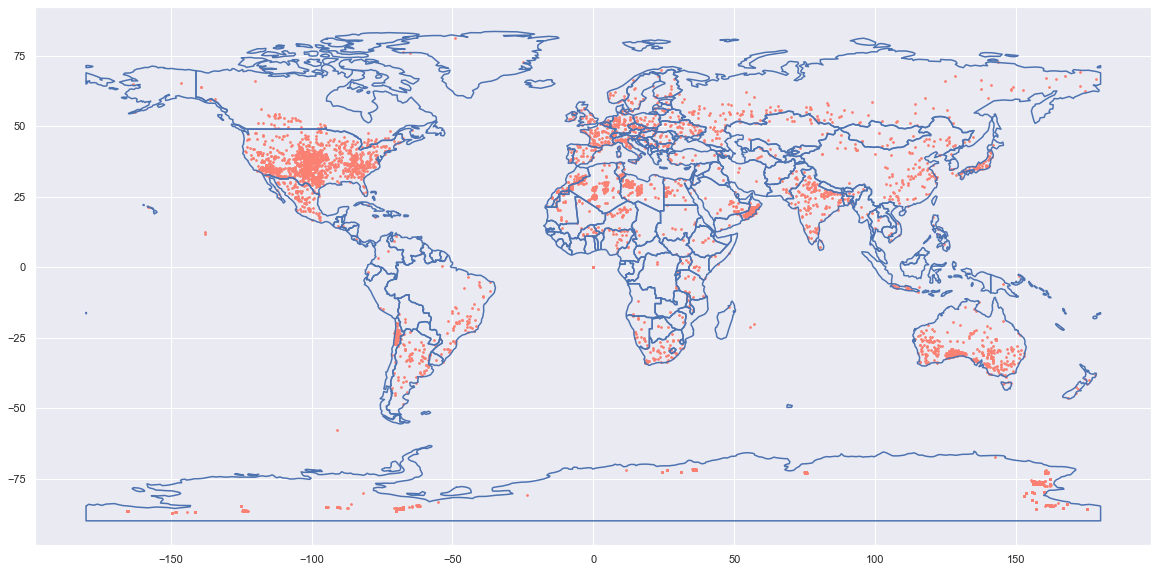

In [130]:
# Import visualization libraries
# pip install shapely
# pip install geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from IPython.display import display

geometry = [Point(xy) for xy in zip(meteorite_data['reclong'], meteorite_data['reclat'])]
gdf = GeoDataFrame(meteorite_data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.boundary.plot(figsize=(20, 12)), marker='o', color='salmon', markersize=3);


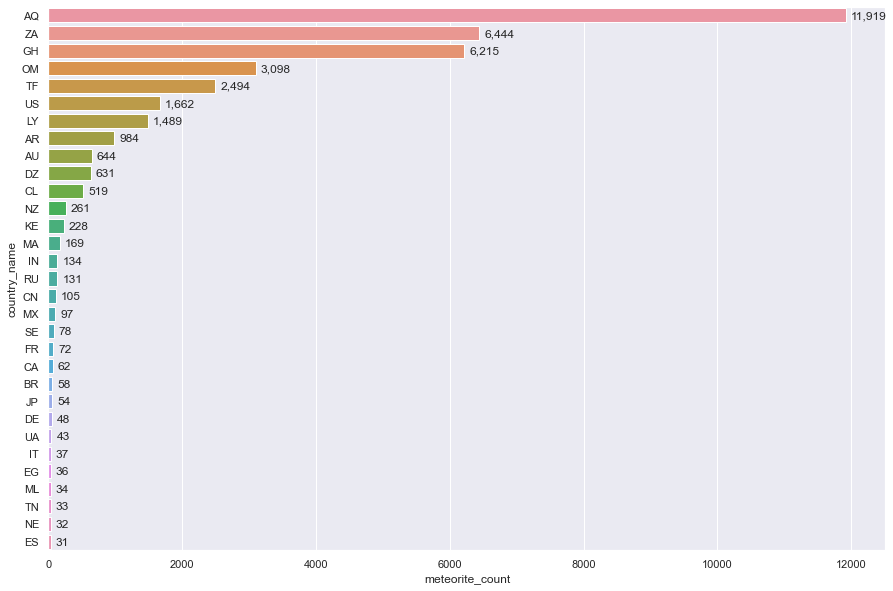

In [131]:
sns.set(rc={"figure.figsize":(15, 10)})
meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_name']).size().reset_index(name='meteorite_count'))
meteorite_counts.sort_values(by='meteorite_count', ascending=False, inplace=True)
# print(meteorite_counts['meteorite_count'].value_counts())

mask = meteorite_counts['meteorite_count'] > 25
g = sns.barplot(data=meteorite_counts[mask], x='meteorite_count', y='country_name')

for p in g.patches:
    pass
    _x = p.get_x() + p.get_width() + float(75)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.25)
    value = '{:,.0f}'.format(p.get_width())
    # value = '{:.1f}'.format(p.get_width())
    g.text(_x, _y, value, ha="left")

# print(meteorite_counts)


In [259]:
mask = meteorite_data['country_name'] == 'United States'
meteorite_counts = pd.DataFrame(meteorite_data[mask].groupby(['admin1', 'admin2']).size().reset_index(name='meteorite_count'))
meteorite_counts.rename(columns={'admin1':'state', 'admin2': 'county'}, inplace=True)

meteorite_counts.set_index(['state', 'county'], inplace=True)
population_data.set_index(['state', 'county'], inplace=True)

us_county_data = pd.concat([population_data, meteorite_counts], axis=1)
us_county_data.fillna(0, inplace=True)

# print(meteorite_counts)
# print(population_data)
print(us_county_data)


                           population  meteorite_count
state   county                                        
Alabama Autauga County        56145.0              0.0
        Baldwin County       229287.0              0.0
        Barbour County        24589.0              0.0
        Bibb County           22136.0              0.0
        Blount County         57879.0              0.0
...                               ...              ...
Wyoming Sweetwater County     42673.0              1.0
        Teton County          23497.0              0.0
        Uinta County          20215.0              0.0
        Washakie County        7760.0              0.0
        Weston County          6743.0              1.0

[3152 rows x 2 columns]


In [266]:
us_county_data[us_county_data['meteorite_count'] > 5].sort_values(by='meteorite_count', ascending=False)

,,population,meteorite_count
state,county,,
California,San Bernardino County,2189183.0,165.0
New Mexico,Roosevelt County,18350.0,121.0
Arizona,Mohave County,217206.0,56.0
Nevada,Pershing County,6573.0,47.0
California,Kern County,901362.0,29.0
Texas,Gaines County,21996.0,20.0
Nevada,Clark County,2315963.0,19.0
New Mexico,Curry County,48793.0,18.0
Nevada,Nye County,48054.0,17.0


(-1.0, 25.0)

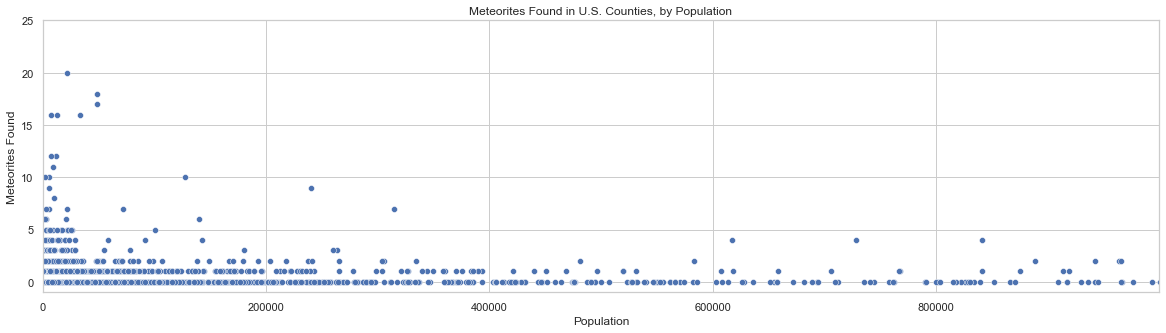

In [272]:
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")
sns.scatterplot(data=us_county_data, x='population', y='meteorite_count')
plt.title("Meteorites Found in U.S. Counties, by Population")
plt.ylabel("Meteorites Found")
plt.xlabel("Population")
plt.xlim(0, 999999)
plt.ylim(-1,25)

Text(0.5, 0, 'Population')

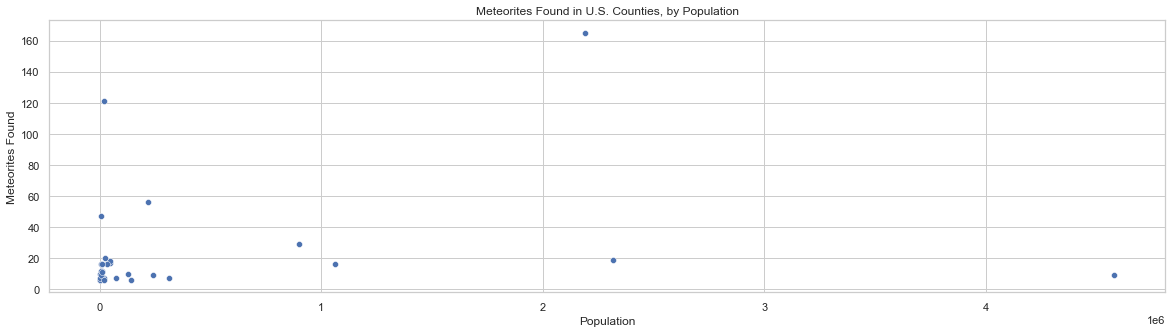

In [273]:
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")
sns.scatterplot(data=us_county_data[us_county_data['meteorite_count'] > 5], x='population', y='meteorite_count')
plt.title("Meteorites Found in U.S. Counties, by Population")
plt.ylabel("Meteorites Found")
plt.xlabel("Population")
# plt.xlim(0, 999999)
# plt.ylim(0,25)

In [66]:
# geometry = [Point(xy) for xy in zip(meteorite_data['reclong'], meteorite_data['reclat'])]
# gdf = GeoDataFrame(meteorite_data, geometry=geometry)   

#this is a simple map that goes with geopandas


print(world.geometry.geom_type.value_counts())
print(world.head())
# meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_name']).size().reset_index(name='meteorite_count'))
# meteorite_counts.set_index(['country_name'], inplace=True)
# meteorite_counts.fillna(0)

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world['meteorite_count'] = meteorite_counts['meteorite']
# world.plot

Polygon         148
MultiPolygon     28
dtype: int64
     pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  gdp_per_cap  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     0.009093   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...     0.002791   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...     0.001503   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...     0.046991   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...     0.056823   

   meteorite_count  
0              1.0  
1            631.0  
2           